In [1]:
using Colors
using Flux 
using Plots
using Statistics

In [293]:
function create_encoder(num_words::Int64, 
                        hidden_sizes::Vector{Int64}, 
                        word_sidelength::Int64)
    layers = []

    for h ∈ 0:length(hidden_sizes)
        if h == 0
            num_in  = num_words
            num_out = hidden_sizes[1]
            σ       = relu
        elseif h == length(hidden_sizes)
            num_in  = hidden_sizes[end]
            num_out = word_sidelength^2
            σ       = sigmoid
        else
            num_in  = hidden_sizes[h]
            num_out = hidden_sizes[h+1]
            σ       = relu
        end

        push!(layers, Dense(num_in, num_out, σ))
    end

    # This epsiode is brought to you by SquareShape
    square_shape = (word_sidelength, word_sidelength)
    
    # Add a final layer to shape it into a square, 4d for convolution
    push!(layers, x -> reshape(x, (square_shape..., 1, 1)))

    return Chain(layers...)
end

create_encoder (generic function with 1 method)

In [294]:
function kernel_size_reduction(input, kernel, padding, stride)
    return ((input - kernel + 2 * padding) / stride) + 1
end

function maxpool_size_reduction(input, pool_size, stride)
    return ((input - pool_size) / stride) + 1
end

total_size_reduction = (y->maxpool_size_reduction(y, 2,2))∘(x->kernel_size_reduction(x, 3,1,1))

var"#741#743"() ∘ var"#742#744"()

In [295]:
function create_decoder(num_words::Int64, 
                        num_CNN_layers::Int64, 
                        final_CNN_layer_size::Int64, 
                        word_sidelength::Int64)	
    
    layers   = []
    channels = [1; 8 * 2 .^ (0:(num_CNN_layers-1))]
    for i in 2:(num_CNN_layers+1)
        push!(layers, Conv((3, 3), channels[i-1]=>channels[i], pad=(1,1), relu))
        push!(layers, x -> maxpool(x, (2,2)))
    end
    
    # Reshape 3d tensor into a 2d one, at this point it should be (final_CNN_layer_size, final_CNN_layer_size, 16*2^num_CNN_layers, 1)
    # which is where we get the 288 in the `Dense` layer below:
    push!(layers, x -> flatten(x))
    
    # Add the final layer
    push!(layers, Dense(final_CNN_layer_size*final_CNN_layer_size*channels[end], num_words))
    
    # Finally, softmax to get nice probabilities
    push!(layers, softmax)

    return Chain(layers...)

end

create_decoder (generic function with 2 methods)

In [296]:
# Helper function that applies a function f to itself n times
composition(f, n) = ∘(ntuple(_ -> f, n)...)

composition (generic function with 1 method)

In [297]:
# Number of words in the vocabulary
num_words = 9

# Converts an integer into a vector with zeros everywhere except for a one in the given entry.
function word2vec(word::Int64)
    return Flux.onehot(word, 1:num_words)
end

word2vec (generic function with 1 method)

In [393]:
# The size of the encoder network's hidden layers
hidden_sizes    = [64,128]

# The number of identical CNN layers (3x3 kernel -> 2x2 max pooling)
num_CNN_layers = 1

# The images which make up the words will be (word_sidelength x word_sidelength) pixels squared
word_sidelength = 6

# Determine whether the chosen size of the word image will be compatible with the convolutional neural network
final_CNN_layer_size = composition(total_size_reduction, num_CNN_layers)(word_sidelength)
error_message        = "Error: The chosen image size will not result in a viable final size for the decoder CNN final layer.\n\n"

try 
    final_CNN_layer_size = convert(Int, final_CNN_layer_size)
    init_speak  = create_encoder(num_words, hidden_sizes, word_sidelength)
    init_listen = create_decoder(num_words, num_CNN_layers, final_CNN_layer_size, word_sidelength)
catch error
    if isa(error, InexactError)
        print(error_message)
    end
end

Chain(Conv((3, 3), 1=>8, relu), #745, #746, Dense(72, 9), softmax)

In [394]:
function visualise_speech(word::Array{Float32})
    if length(size(word)) > 2
        word = word[:,:,1,1]
    end

    matrix = Gray.(word)
    return plot(matrix, xaxis=nothing, yaxis=nothing)
end

visualise_speech (generic function with 1 method)

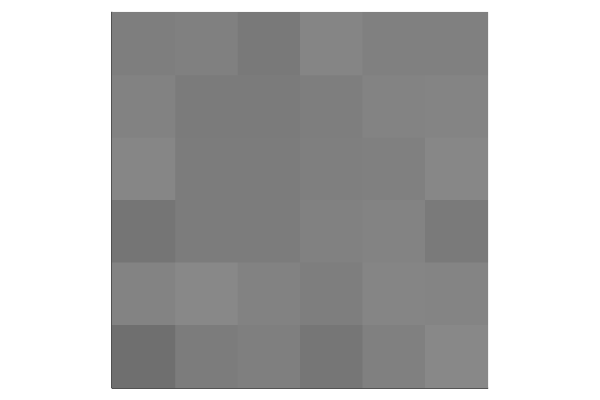

In [395]:
visualise_speech(init_speak(word2vec(1)))

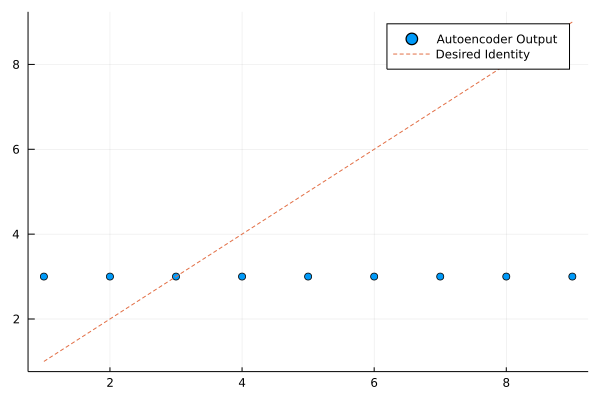

In [396]:
x = 1:num_words

η =  argmax ∘ vec ∘ init_listen ∘ init_speak ∘ (x->word2vec(x))
plot(x, η.(x), seriestype=:scatter, label="Autoencoder Output")
plot!(x, x, ls=:dash, label="Desired Identity")

In [397]:
# Computes the similarity between two vectors by exponentiating their squared difference 
function similarity(arr1::Array{Float64}, arr2::Array{Float64},
                    strictness::Float64)
    return exp(  -sum((arr1 .- arr2).^2) / strictness )
end

function similarity(arr1::Array{Float32}, arr2::Array{Float32},
                    strictness::Float64)
    return similarity(1.0*arr1, 1.0*arr2, strictness)
end

# Makes an array giving the local averages for a larger array using mean pooling
function local_average(array::Array{Float32}, kernel_size::Tuple{Int64, Int64})
    reshaped = 1.0*reshape(array, (word_sidelength, word_sidelength, 1, 1))

    return MeanPool(kernel_size, stride=1)(reshaped)
end

# Compares the local similarity between two arrays by taking local averages and then comparing them
function local_similarity(arr1::Array{Float32}, arr2::Array{Float32},
                         kernel_size::Tuple{Int64, Int64},
                         strictness::Float64)

    avg1 = 1.0*local_average(arr1, kernel_size)
    avg2 = 1.0*local_average(arr2, kernel_size)

    return similarity(avg1, avg2, strictness)
end

local_similarity (generic function with 1 method)

In [402]:
speak  = deepcopy(init_speak)
listen = deepcopy(init_listen)
autoencoder = Chain(speak, listen)

optimiser = ADAM()
θ = params(autoencoder)

iterations = 15
words   = [(a,b) for a in 1:num_words for b in 1:num_words]

losses = Float64[]
for _ in 1:iterations
    iteration_losses = []
    for i in 1:length(words)
        
        # Get the words on which to train
        trainword  = word2vec(words[i][1])
        trainword2 = word2vec(words[i][2])
        
        # Update to push the listeners closer to understanding
        grads = gradient(() -> lossfor_understanding(trainword , trainword), θ) 
        Flux.Optimise.update!(optimiser, θ, grads)
        
        # Total loss so far
#         push!(iteration_losses, lossfor_understanding(trainword, trainword))
        push!(iteration_losses, lossfor_understanding(trainword , trainword))
        
    end
    
    push!(losses, mean(iteration_losses))
end

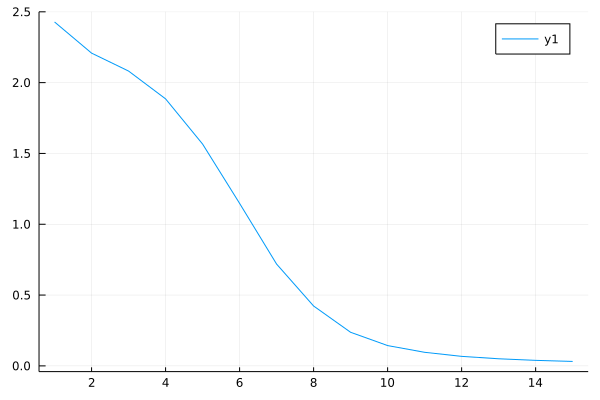

In [403]:
plot(losses)

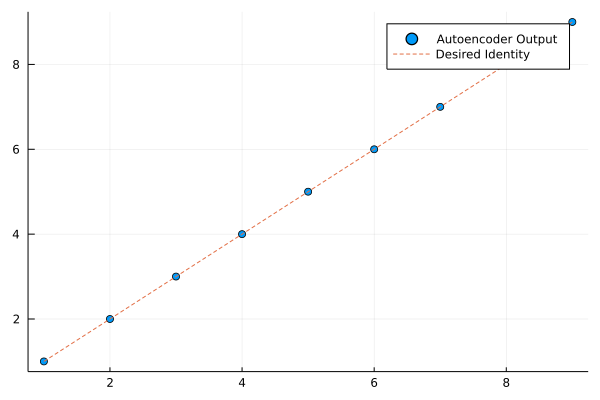

In [404]:
η_trained = argmax ∘ vec ∘ listen ∘ speak ∘ (x->word2vec(x))
plot(1:num_words, η_trained.(1:num_words), seriestype=:scatter, label="Autoencoder Output")
plot!(1:num_words, 	1:num_words, ls=:dash, label="Desired Identity")

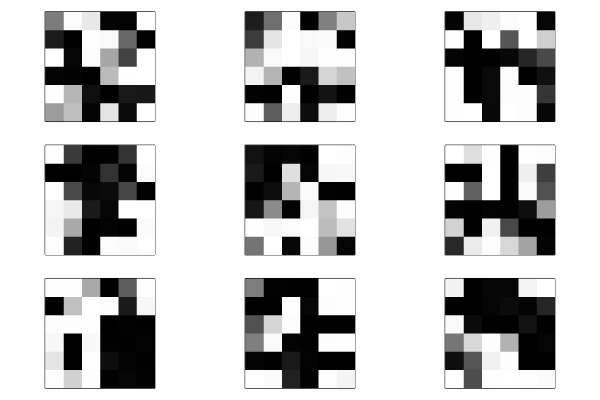

In [405]:
vocabulary_plots = [visualise_speech(speak(word2vec(x))) for x in 1:num_words]
plot(vocabulary_plots..., layout=(3,3), framestyle = :box)

##### 